In [12]:
%load_ext autoreload
%autoreload 1

In [159]:
%autoreload

In [37]:
import matplotlib.pyplot as plt

In [19]:
from monai.transforms import RandRotated

In [54]:
from ulw_data.torch_dataset.challenge_data_pipeline import train_data_pipeline

In [1044]:
collated_folder = "/media/benp/NVMEspare/datasets/full_WMH_Chal_dataset/preprocessed/collated/"
train_ds_3D, val_ds_3D = train_data_pipeline(collated_folder, 0.15, 5, None, 3)

In [1045]:
train_ds_2D, val_ds_2D = train_data_pipeline(collated_folder, 0.15, 5, None, 2)

In [163]:
train_ds_3D[0]['image'].shape, train_ds_2D[0]['image'].shape, train_ds_2D[0]['label'].shape

(torch.Size([3, 192, 224, 64]),
 torch.Size([3, 192, 224]),
 torch.Size([1, 192, 224]))

In [ ]:
#train_ds_3D[0]

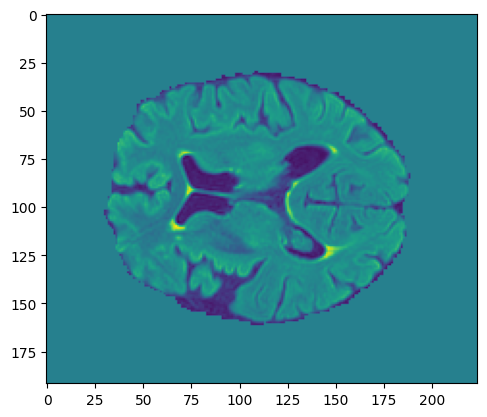

In [60]:
plt.imshow(train_ds_3D[0]['image'][0,:,:,33])

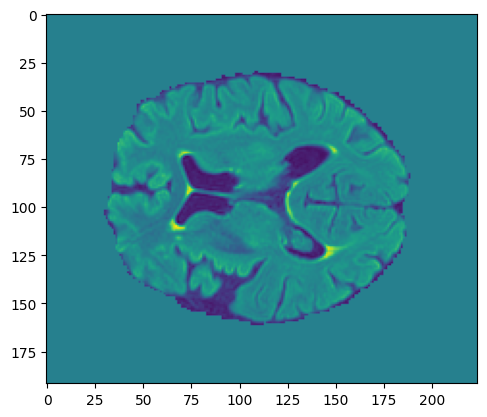

In [61]:
plt.imshow(train_ds_2D[22]['image'][0])

### implementing the nn-Unet augmentations

In [369]:
from monai.transforms import MapTransform
from abc import abstractmethod
class MonaiAugmentationExtender(MapTransform):
    def __init__(self, p:float, dims:int=2, keys=['image', 'label'], mode=None, *args, **kwargs):
        super().__init__(keys=keys, *args, **kwargs)
        assert dims == 2 or dims == 3
        assert 0 <= p <= 1
        self.dims = dims # 2 for 2D, 3 for 3D
        self.mode= mode # modes are used where we treat labels and images differently.
        self.p = p # p is probability of applying the transform.

    @abstractmethod
    def __call__(self, data):
        pass

class MonaiAugmentationWrapper(MonaiAugmentationExtender):
    # needs to have base_augmentation defined in the constructor
    def __call__(self, data):
        return self.base_augmentation(data)

### rotation

In [370]:
from monai.transforms import RandRotated
class RotationAugment(MonaiAugmentationWrapper):
    def __init__(self, axial_only=False, *args, **kwargs):
        super().__init__(*args, mode=['bilinear', 'nearest'], **kwargs)
        
        degrees_3D=(-30,30)
        degrees_2D =(-180,180)

        if axial_only and self.dims == 3:
            range_x = range_y = (0,0)
            range_z = degrees_2D

        elif self.dims == 3:
            range_x = range_y = range_z = degrees_3D

        elif self.dims == 2:
            range_x = range_y = range_z = degrees_2D

        self.base_augmentation = RandRotated(
            keys=self.keys,
            mode=self.mode,
            range_x=range_x,
            range_y=range_y,
            range_z=range_z,
            keep_size=True,
            prob=self.p
        )
            

In [371]:
rotator = RandRotated(keys=['image'], range_x=30, range_z=(30), range_y=(0), prob=1, keep_size=True, mode='bilinear')

In [372]:
rotator_custom = RotationAugment(p=1, dims=2)

In [373]:
out3d = rotator(train_ds_2D[0])

In [376]:
out = rotator_custom(train_ds_2D[22])

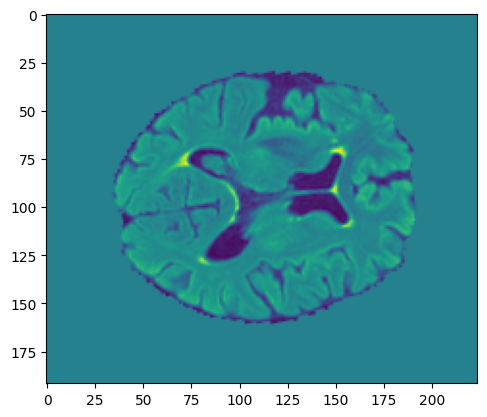

In [377]:
plt.imshow(out['image'][0])

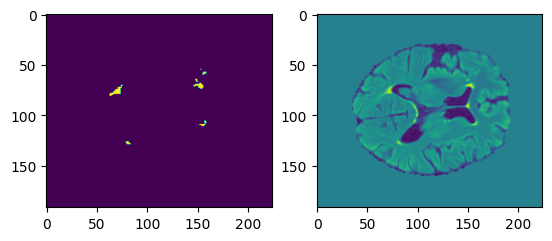

In [378]:
plt.subplot(1,2,1)
plt.imshow(out['label'][0])
plt.subplot(1,2,2)
plt.imshow(out['image'][0])

In [379]:
out['label'][0].unique()

tensor([0., 1.])

In [176]:
for data in train_ds_3D:
    print(data['label'].unique())

tensor([0., 1.], dtype=torch.float64)
tensor([0., 1.], dtype=torch.float64)
tensor([0., 1.], dtype=torch.float64)
tensor([0., 1.], dtype=torch.float64)
tensor([0., 1.], dtype=torch.float64)
tensor([0., 1.], dtype=torch.float64)
tensor([0., 1.], dtype=torch.float64)
tensor([0., 1.], dtype=torch.float64)
tensor([0., 1., 2.], dtype=torch.float64)
tensor([0., 1.], dtype=torch.float64)
tensor([0., 1.], dtype=torch.float64)
tensor([0., 1.], dtype=torch.float64)
tensor([0., 1., 2.], dtype=torch.float64)
tensor([0., 1., 2.], dtype=torch.float64)
tensor([0., 1.], dtype=torch.float64)
tensor([0., 1., 2.], dtype=torch.float64)
tensor([0., 1., 2.], dtype=torch.float64)
tensor([0., 1., 2.], dtype=torch.float64)
tensor([0., 1.], dtype=torch.float64)
tensor([0., 1., 2.], dtype=torch.float64)
tensor([0., 1., 2.], dtype=torch.float64)
tensor([0., 1.], dtype=torch.float64)
tensor([0., 1., 2.], dtype=torch.float64)
tensor([0., 1., 2.], dtype=torch.float64)
tensor([0., 1., 2.], dtype=torch.float64)
tensor

In [380]:
import torch

In [381]:
example_mask = torch.zeros((100,100))
example_mask[20:40, 20:40] = 1
example_mask[80:95, 65:72] = 2

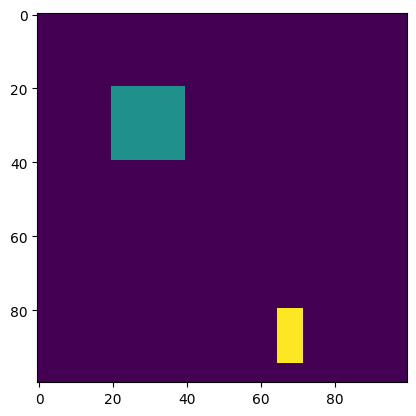

In [382]:
plt.imshow(example_mask)

In [383]:
train_ds_3D[0]['image'].shape

torch.Size([3, 192, 224, 64])

In [384]:
example_input = {
    'image' : torch.zeros((1, 1, 100,100)),
    'label' : example_mask.unsqueeze(0).unsqueeze(0)
}

In [385]:
out = rotator_custom(example_input)

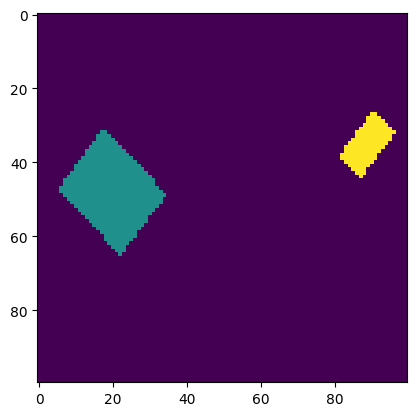

In [386]:
plt.imshow(out['label'].squeeze())

### scaling

In [997]:
### TODO REPLACE ROTATION AND SCALING WITH A SINGLE
# AFFINE TRANSFORM OBJECT, SO THAT IT ONLY HAS TO DO THE
# INTERPOLATION PROCEDURE ONCE, MORE EFFICIENT!

from monai.transforms import RandAffined
class AffineAugment(MonaiAugmentationExtender):
    def __init__(self, spatial_size, axial_only=False, *args, **kwargs):
        """
        spatial size should be the output size I want I think? (or just the size of the data
        , i.e dont change the size
        I should do the affine translation and then centre crop perhaps? I'm not really sure how the
        spatial dim stuff works at the moment, and when I try 3D I should think about this.
        """
        super().__init__(*args, mode=['bilinear', 'nearest'], **kwargs)
        self.spatial_size = spatial_size

        pi = np.pi

        ### setup rotation range
        degrees_3D=(-30 * pi/180,30 * pi/180)
        degrees_2D = (-pi,pi)

        if axial_only and self.dims == 3:
            range_x = range_z = (0,0)
            range_y = degrees_2D

        elif self.dims == 3:
            range_x = range_y = range_z = degrees_3D

        elif self.dims == 2:
            range_x = range_y = range_z = degrees_2D

        self.rotate_range = (*range_x, *range_y, *range_z)

        ### setup translation range
        translation_scale = 0.1
        self.translate_range = [(-s * translation_scale, s * translation_scale) for s in spatial_size]

        ### setup scale range
        scale_min = -0.3
        scale_max = 0.4
        self.scale_range = (scale_min, scale_max, scale_min, scale_max, scale_min, scale_max)

        ### setup shear range
        shear_angle = 18 * pi/180
        if axial_only and self.dims == 3:
            self.shear_range = (0, 0, -shear_angle, shear_angle, 0,0)
        else:
            self.shear_range = (-shear_angle, shear_angle, -shear_angle, shear_angle, -shear_angle)
        

    def __call__(self, data):
        # decide whether to call augmentation:
        do_rotation = np.random.uniform(0,1) < self.p 
        do_scale = np.random.uniform(0,1) < self.p
        do_translate = np.random.uniform(0,1) < self.p
        do_shear = np.random.uniform(0,1) < self.p

        if not do_rotation and not do_scale and not do_translate and not do_shear:
            return data

        rotate_range = self.rotate_range if do_rotation else None
        print(rotate_range)
        scale_range = self.scale_range if do_scale else None
        translate_range = self.translate_range if do_translate else None
        shear_range = self.shear_range if do_shear else None

        augment = RandAffined(
            keys=self.keys,
            mode=self.mode,
            spatial_size=self.spatial_size, 
            prob=1,
            rotate_range=rotate_range,
            scale_range=scale_range,
            translate_range=translate_range,
            shear_range=shear_range,
            padding_mode='zeros'
        )

        return augment(data)

In [973]:
np.pi

3.141592653589793

In [995]:
affine_test3d = AffineAugment(p=1, spatial_size=(180, 240, 64), dims=3, axial_only=True)

(0, 0, -3.141592653589793, 3.141592653589793, 0, 0)


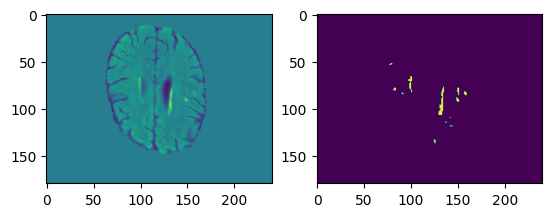

In [996]:
cout3d = affine_test3d(train_ds_3D[0])
plt.subplot(1,2,1)
plt.imshow(cout3d['image'][0,:,:,33], vmin=-3, vmax=4)
plt.subplot(1,2,2)
plt.imshow(cout3d['label'][0,:,:,33])

In [908]:
np.array([(s* -0.1, s * 0.1) for s in (192, 224)]).flatten()

array([-19.2,  19.2, -22.4,  22.4])

In [776]:
# affine_test = RandAffined(
#             keys=['image'],
#             spatial_size=(192, 224), 
#             prob=1,
#             rotate_range=None,
#             scale_range=None,
#             translate_range=((-19.5,19.5), (-22,22), (100,100)),
#             shear_range=None,
#         )

affine_test = AffineAugment(p=1, spatial_size=(192, 224))

In [777]:
train_ds_2D[0]['label'].shape

torch.Size([1, 192, 224])

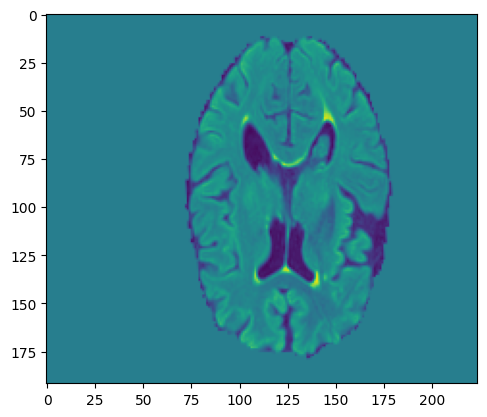

In [793]:
cout = affine_test(train_ds_2D[22])
plt.imshow(cout['image'][0], vmin=-3, vmax=4)

### gaussian noise

In [388]:
from monai.transforms import RandGaussianNoised

class GaussianNoiseAugment(MonaiAugmentationWrapper):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, keys=['image'], **kwargs)
        self.base_augmentation = RandGaussianNoised(
            keys=self.keys,
            prob=self.p,
            mean=0,
            std=0.4 # this parameter is the top end of the rane that the noise is sampled from (I think)
        )

In [389]:
noiser = GaussianNoiseAugment(p=1, dims=2)

In [390]:
noised = noiser(train_ds_2D[22])

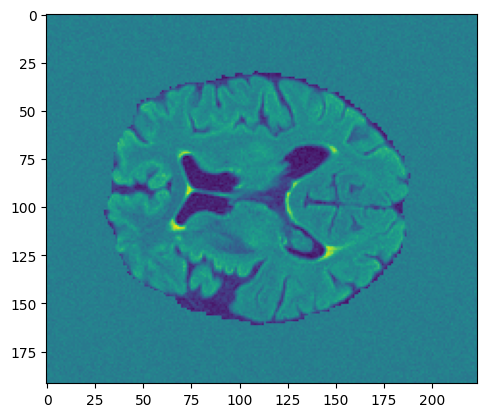

In [391]:
plt.imshow(noised['image'][0])

### gaussian blur

In [1060]:
from monai.transforms import RandGaussianSmooth

class GaussianBlurAugment(MonaiAugmentationExtender):
    def __init__(self, modality_p, *args, **kwargs):
        super().__init__(*args, keys=['image'], **kwargs)
        self.modality_p = modality_p
        self.base_augmentation = RandGaussianSmooth(
            prob=self.modality_p,
            sigma_x=(0.5,1.5),
            sigma_y=(0.5,1.5),
            sigma_z=(0.5,1.5),
        )
        print(self.p)
        print(self.modality_p)

    def __call__(self, data):
        if np.random.uniform(0,1) > self.p:
            print("returning")
            return data

        for key in self.keys:
            key_data = data[key].clone()
            for channel in range(key_data.shape[0]):
                channel_data = key_data[channel].unsqueeze(0)
                channel_data = self.base_augmentation(channel_data)
                key_data[channel] = channel_data

            data[key] = key_data
        return data

In [1073]:
blurer = GaussianBlurAugment(p=1, dims=2, modality_p=0.5)

1
0.5


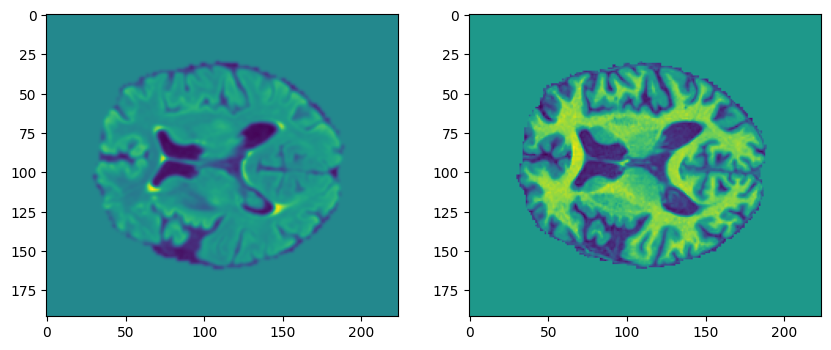

In [1079]:
plt.figure(figsize=(10,5))
bout = blurer(train_ds_2D[22])
plt.subplot(1,2,1)
plt.imshow(bout['image'][0])
plt.subplot(1,2,2)
plt.imshow(bout['image'][1])

### brightness

In [418]:
from monai.transforms import RandScaleIntensityd

class BrightnessAugment(MonaiAugmentationWrapper):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, keys=['image'], **kwargs)
        # monai uses v = v * (1 + factor)
        # I want to multiply by range 0.7, to 1.3,, so in range -0.3, to 0.3
        self.base_augmentation = RandScaleIntensityd(
            keys=self.keys,
            factors=(-0.3,0.3),
            prob=self.p,
        )

In [419]:
brightness = BrightnessAugment(p=1)

tensor(4.1445, dtype=torch.float64) tensor(-3.1808, dtype=torch.float64)


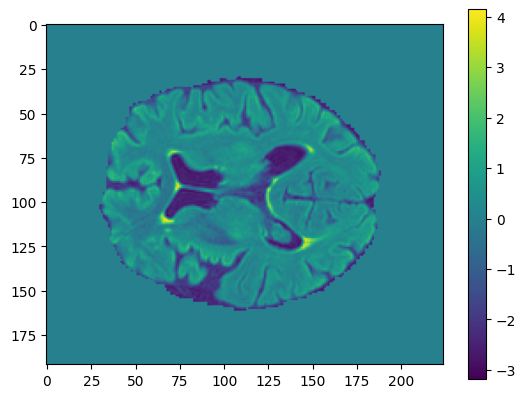

In [434]:
img = train_ds_2D[22]['image'][0]
plt.imshow(img); plt.colorbar()
print(img.max(), img.min())

tensor(3.6634) tensor(-2.8115)


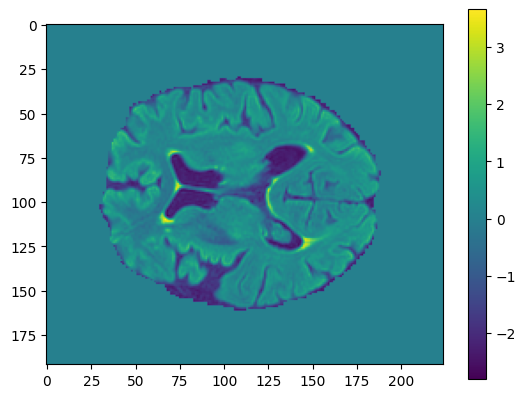

In [450]:
bout = brightness(train_ds_2D[22])
plt.imshow(bout['image'][0]); plt.colorbar()
print(bout['image'][0].max(), bout['image'][0].min())

### contrast

In [495]:
from monai.transforms import RandAdjustContrastd

class ContrastAugment(MonaiAugmentationWrapper):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, keys=['image'], **kwargs)
        self.base_augmentation = RandAdjustContrastd(
            keys=self.keys,
            prob=self.p,
            gamma=(0.65,1.5)
        )

In [496]:
contrast = ContrastAugment(p=1)

tensor(4.1445, dtype=torch.float64) tensor(-2.8115)


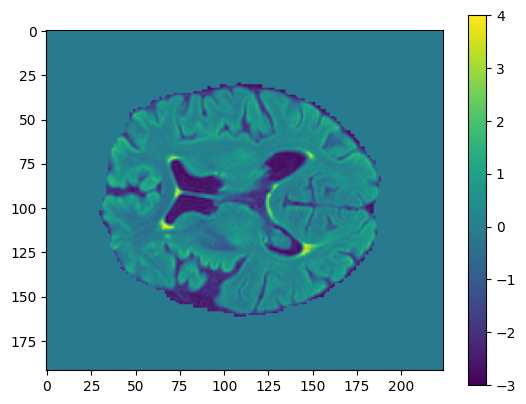

In [497]:
cout = contrast(train_ds_2D[22])
plt.imshow(cout['image'][0], vmin=-3, vmax=4); plt.colorbar()
print(cout['image'][0].max(), bout['image'][0].min())

### simulation of low resolution

In [1097]:
from torchvision.transforms.functional import resize
from torchvision.transforms import InterpolationMode
import numpy as np

class LowResolutionSimulationAugmentation(MonaiAugmentationExtender):
    def __init__(self, modality_p, *args, **kwargs):
        super().__init__(*args, keys=['image'], **kwargs)
        self.modality_p = modality_p

    def __call__(self, data):
        # decide whether to call augmentation:
        if np.random.uniform(0,1) > self.p:
            return data

        # generate downsample factor
        factor = np.random.uniform(0.5, 1)
        print(factor)

        for key in self.keys:
            if key not in data:
                raise KeyError(f"key {key} not found and allow_missing_keys==False for this augmentation")

            key_data = data[key].clone()
            for channel in range(key_data.shape[0]):
                if np.random.uniform(0,1) < self.modality_p:
                    print(key_data[channel].shape)
                    channel_data = key_data[channel].unsqueeze(0)
                    spatial_dims = np.array(channel_data.shape[1:])
                    downsampled_size = np.round(spatial_dims * factor).astype(np.int32)
        
                    downsampled = resize(channel_data, downsampled_size, interpolation=InterpolationMode.NEAREST)
                    upsampled = resize(downsampled, spatial_dims, interpolation=InterpolationMode.BICUBIC, antialias=True)
                    print(upsampled.squeeze().shape)
                    key_data[channel] = upsampled.squeeze()
            data[key] = key_data
            
        return data

In [1098]:
lowres = LowResolutionSimulationAugmentation(p=1, modality_p=0.5)

0.5988370864038959
torch.Size([192, 224])
torch.Size([192, 224])
torch.Size([192, 224])
torch.Size([192, 224])


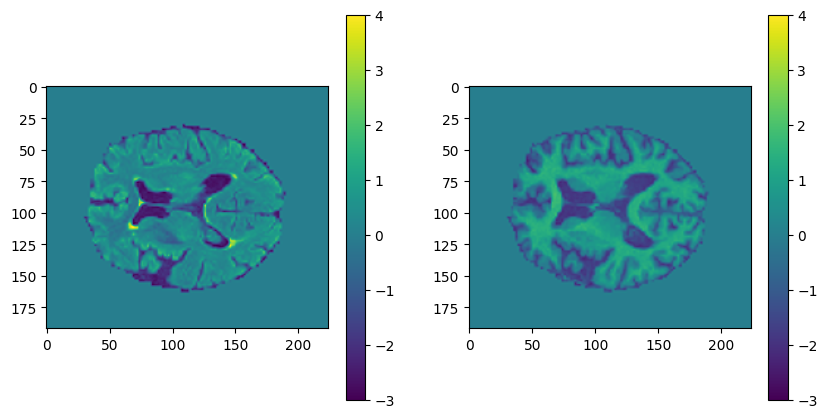

In [1110]:
cout = lowres(train_ds_2D[22])
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(cout['image'][0], vmin=-3, vmax=4); plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(cout['image'][1], vmin=-3, vmax=4); plt.colorbar()

In [509]:
np.round(np.array(train_ds_3D[0]['image'].shape[1:]) * 0.6).astype(np.int32)

array([115, 134,  38], dtype=int32)

### gamma augmentation

In [623]:
class GammaAugmentation(MonaiAugmentationExtender):
    def __init__(self, *args, allow_invert=True, **kwargs):
        super().__init__(*args, keys=['image'], **kwargs)
        self.allow_invert=allow_invert
    
    def __call__(self, data):
        # decide whether to call augmentation:
        if np.random.uniform(0,1) > self.p:
            return data

        gamma = np.random.uniform(0.7, 1.5)

        invert = self.allow_invert and np.random.uniform(0,1) < 1#0.15

        for key in self.keys:
            if key not in data:
                raise KeyError(f"key {key} not found and allow_missing_keys==False for this augmentation")

            key_data = data[key]

            # 0, 1 scale
            drange = (key_data.min(), key_data.max())
            key_data = (key_data - drange[0]) / (drange[1] - drange[0])

            # gamma scale
            if invert:
                key_data = 1 - (1-key_data).pow(gamma)
            else:
                key_data = key_data.pow(gamma)

            # original range scale
            key_data = key_data * (drange[1] -drange[0]) + drange[0]
            
            data[key] = key_data

        return data

tensor(4.1445, dtype=torch.float64) tensor(-2.8115)


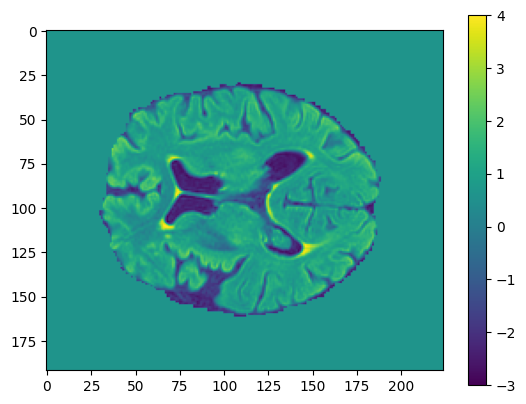

In [624]:
gamma = GammaAugmentation(p=1, allow_invert=True)
cout = gamma(train_ds_2D[22])
plt.imshow(cout['image'][0], vmin=-3, vmax=4); plt.colorbar()
print(cout['image'][0].max(), bout['image'][0].min())

### mirroring

In [1125]:
from monai.transforms import RandFlipd
class MirrorAugment(MonaiAugmentationExtender):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.flip0 = RandFlipd(keys=self.keys, prob=self.p, spatial_axis=0)
        self.flip1 = RandFlipd(keys=self.keys, prob=self.p, spatial_axis=1)
        self.flip2 = RandFlipd(keys=self.keys, prob=self.p, spatial_axis=2)

    def __call__(self, data):
        # todo: is this nessesary? what happens if I ignore this?
        if self.dims == 2:
            return self.flip0(data)
        else:
            return self.flip0(self.flip1(self.flip2(data)))

    

In [1126]:
mirror_transform = MirrorAugment(p=0.5, dims=2)

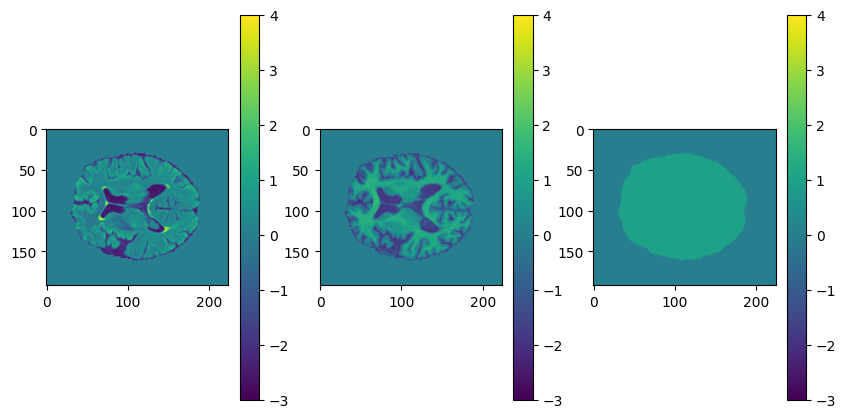

In [1149]:
cout = mirror_transform(train_ds_2D[22])
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.imshow(cout['image'][0], vmin=-3, vmax=4); plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(cout['image'][1], vmin=-3, vmax=4); plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(cout['image'][2], vmin=-3, vmax=4); plt.colorbar()

### Binary operators

In [1150]:
# I will leave this for now so that I can get training.

### Removal of small connected components

In [1151]:
# I will leave this for now so that I can get training.

### Composite augmentations

In [1152]:
# put in the probabilities for nn-unet and provide a 2D and 3D version. Nice.

from monai.transforms import Compose

def get_nnunet_transforms(axial_only, dims, out_spatial_dims=(192, 224), allow_invert=True):
    """
    axial only: only apply rotation and shearing in the axial plane, for 3D data
    out_spatial_dims: the output image size from the affine transformation
    dims: 2 for 2D, 3 for 3D
    allow_invert: allow gamma augmentation to be computed on inverse intensities
    """
    assert dims==2 or dims==3

    return Compose([
        AffineAugment(p=0.2, spatial_size=out_spatial_dims, dims=dims, axial_only=axial_only),
        GaussianNoiseAugment(p=0.15, dims=dims),
        GaussianBlurAugment(p=0.2, modality_p=0.5, dims=dims),
        BrightnessAugment(p=0.15, dims=dims),
        ContrastAugment(p=0.15, dims=dims),
        LowResolutionSimulationAugmentation(p=0.25, modality_p=0.5, dims=dims),
        GammaAugmentation(p=0.15, allow_invert=allow_invert, dims=dims),
        MirrorAugment(p=0.5, dims=dims),
    ])

In [1153]:
transforms_2D = get_nnunet_transforms(axial_only=False, dims=2, out_spatial_dims=(192,224), allow_invert=True)

0.2
0.5


returning


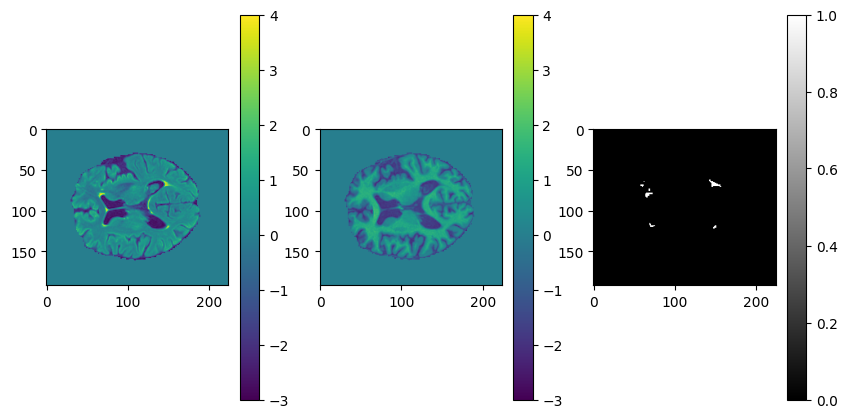

In [1186]:
cout = transforms_2D(train_ds_2D[22])
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.imshow(cout['image'][0], vmin=-3, vmax=4); plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(cout['image'][1], vmin=-3, vmax=4); plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(cout['label'][0], vmin=0, vmax=1, cmap='gray'); plt.colorbar()